In [1]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# AstroML
from astroML.datasets import fetch_LINEAR_sample
from astropy.timeseries import LombScargle
from astroML.datasets import fetch_LINEAR_sample
from astroML.datasets import fetch_LINEAR_geneva
from astropy.timeseries import TimeSeries
from astropy.table import Table
from astroML.time_series import MultiTermFit

# ZTF
from ztfquery import lightcurve

# Basic libraries
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

# DataFrame analysis
import pandas as pd

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm

In [2]:
# CONFIGURATION
# -------------
sns.set_theme(style='white') # setting the theme for plotting
sys.path.insert(0,'../src/')
np.random.seed(42)

# configuring plotting colors
colors = ['#465BBB', '#3F8FCE', '#7ABBCE', '#3A3865', '#A82F43', '#612A37', '#DC5433', '#F29457']
b1 = '#465BBB'
b2 = '#3F8FCE'
b3 = '#7ABBCE'
b4 = '#3A3865'
black1 = '#22212A'
black2 = '#2D1E21'
or1 = '#A82F43'
or2 = '#612A37'
or3 = '#DC5433'
or4 = '#F29457'
muted_colors = sns.set_palette(sns.color_palette(colors))

# configuring fonts for plotting
font = FontProperties()
font.set_family('serif')
font.set_name('Andale Mono')
font.set_style('normal')
#font.set_size('normal')


%matplotlib inline 

*Authors: Ema Donev and dr. Iveić, 2024.*

## Goals

In this project, we will analyze the light curves from the LINEAR database and determine their periods and types. Afterward, we will compare them to the ZTF database of light curves by matching the LINEAR dataset's IDs to the ZTF dataset's ID. Plotting the two light curves, which are ten years apart, should yield new insights into variable star behavior over more extended periods. Our main goal is to search for the **Blazhko effect** in RR Lyrae stars. 

# Introduction

## Variable stars

**Variable stars** are stars that change in brightness or magnitude periodically or semi-periodically. Every periodic variable star has its **period**, a measure between 2 sequential minima and maxima in brightness. The change in the magnitude of a variable star over time is recorded as `time series` data or in a **light curve** format.

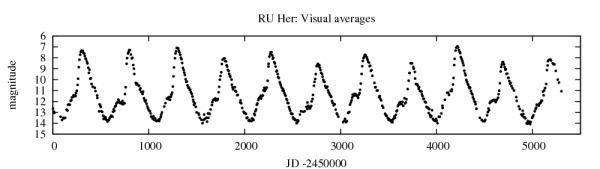

In [1]:
#| label: fig_light_curve
#| fig-cap: An example of a long period variable star. Reference https://www.aavso.org/overview-long-term-visual-light-curves
from IPython.display import Image
Image(filename="../images/light_curve_eg.png")

There are many variable stars, and we can categorize them as **Intrinsic or Extrinsic**. An **Intrinsic** variable star means that the cause of the star's variability is due to its expanding and contracting because of a process called the *Eddington valve*. **Extrinsic** variables are stars whose cause of variability is due to external influences. These can be stars found in binary star systems or whose variability is caused by *rotation*. 

## Intrinsic variable stars
### Pulsating variables

The first and most famous type of variable stars are **pulsating variables**. The pulsation of the entirety of the star causes the variability. There are, of course, multiple ways of pulsation. The first is the *fundamental mode of pulsation*. This mode of pulsation is when the star expands in volume. 

So, most variable stars are older because they stopped fusing hydrogen and started fusing helium, which is crucial for pulsation. In the star, doubly ionized helium is more opaque, meaning that the light from the star or radiation cannot escape efficiently from the core to the surface. Helium absorbs the radiation and slowly heats up due to the extra energy. Due to the expansion of substances because of heat, the helium expands in volume and becomes more ionized. Because helium expands in volume, the layers of the star increase in volume, and the whole star expands. Due to the expansion, it decreases in brightness because less light is radiated per square meter of surface area. However, once the star expands in volume, heat is lost due to a larger surface area, and the temperature starts to drop. Once this process begins, the star begins to contract, the helium becoming less ionized, allowing radiation to escape into space again. Due to the contraction of the layers, more radiation is emitted per square meter, which is the brightest point in the cycle. Because the star heats up again, the entire process is repeated.

A star can technically exhibit infinite pulsation modes. The simplest is called the *fundamental overtone:* this is when all parts of the star expand and contract.The following one is called the *first overtone:* here a <span style="color:CadetBlue">nodal sphere</span> is present, where the layers beneath this sphere *contract* during pulsation the layers of the star after the nodal sphere *expand*. The nodal sphere itself <span style="color:CadetBlue">doesn't expand or contract</span>. The *second overtone* has 2 nodal spheres, the third has 3 nodal spheres, etc.

There is another pulsation mode called a **non-radial** mode. This mode means that the star pulsates not by expansion but by a change in shape. By changing the star's shape due to some parameters, the amount of light reaching Earth varies at different times due to a different amount of visible surface area.

We will describe some important variable star types in the following few sections.

### Cepheid variables and RR Lyrae stars

**Cepheid variables** pulsate in a steady, periodic cycle, and these stars are typically yellow supergiants. Their period ranges from 1 to 100 days, with an amplitude from 0.1 to 2.0 magnitudes. Cepheid variables are famous for exhibiting the period-luminosity relationship, which states that the longer the period of a cepheid, the larger its luminosity or intrinsic brightness is. There are two types of Cepheids:
1. **Classical cepheids or Delta Cepheids**: these stars are O-B type stars.
2. **Type II Cepheids**: These stars are less massive and older than the first type, which means they are population II-type stars. These types of cepheids also follow a different period-luminosity relationship.

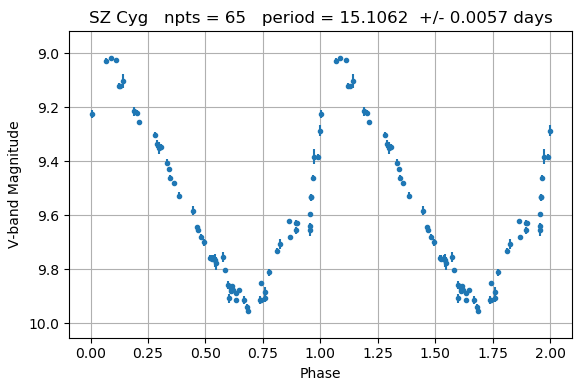

In [5]:
#| label: fig_cepheid
#| fig-cap: light curve of cepheid variables. Reference https://astrolab.awh.durham.ac.uk/cepheid.html
Image(filename="../images/cepheid.png")

**RR Lyrae** stars are very old white giants of A spectral class with low metallicity. Since these variables are old, they are commonly found in globular clusters. RR Lyraes have very short periods, ranging from 0.05 to 1.2 days and 0.3 to 2 magnitudes in amplitude. 

A very peculiar aspect of RR Lyraes is the **Blazhko effect**. This effect needs to be better understood in astronomy, and we do not know why it occurs. The effect states that some variables, notably RR Lyraes, exhibit **modulations in their light curves**, meaning that over some time, their light curves change in amplitude and sometimes in the period. We would like to find more information about this effect by studying RR Lyrae stars for very long periods (with a difference of 10 years, like in this project). 

There are three subtypes of RR Lyrae variables:

1. **RRAB type:** These stars have asymmetrical light curves, with periods from 0.3 to 1.2 days and amplitudes of 0.5 to 2 magnitudes. These types generally pulsate in the fundamental mode.

2. **RRC type:** These stars have nearly symmetrical light curves with periods from 0.2 to 0.5 days and small amplitude changes. These types generally pulsate in the first overtone.

3. **RRD types:** These stars pulsate both in the fundamental and first overtone, with potentially non-radial modes interveening. On average, the more extended period (radial) is 0.74 days, while the shorter period (non-radial) is, on average, 0.5 days.

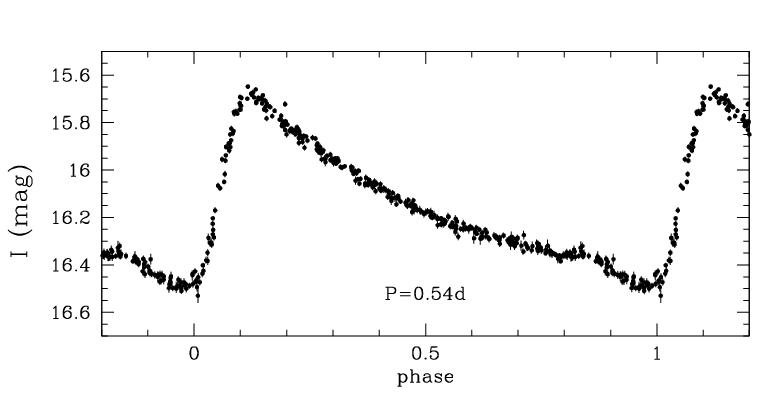

In [6]:
#| label: fig_rrlyrae
#| fig-cap: light curve of an RR Lyrae variable star, REFERENCE https://www.researchgate.net/figure/Example-of-light-curve-of-RR-Lyrae-a_fig7_343309076
Image(filename="../images/rr lyare.jpeg")

## The Blazhko effect

The *Blazhko effect* is one of the mysteries left unsolved regarding variable stars. The effect is when light curves *modulate their phase, shape or amplitude* over a long period of time.

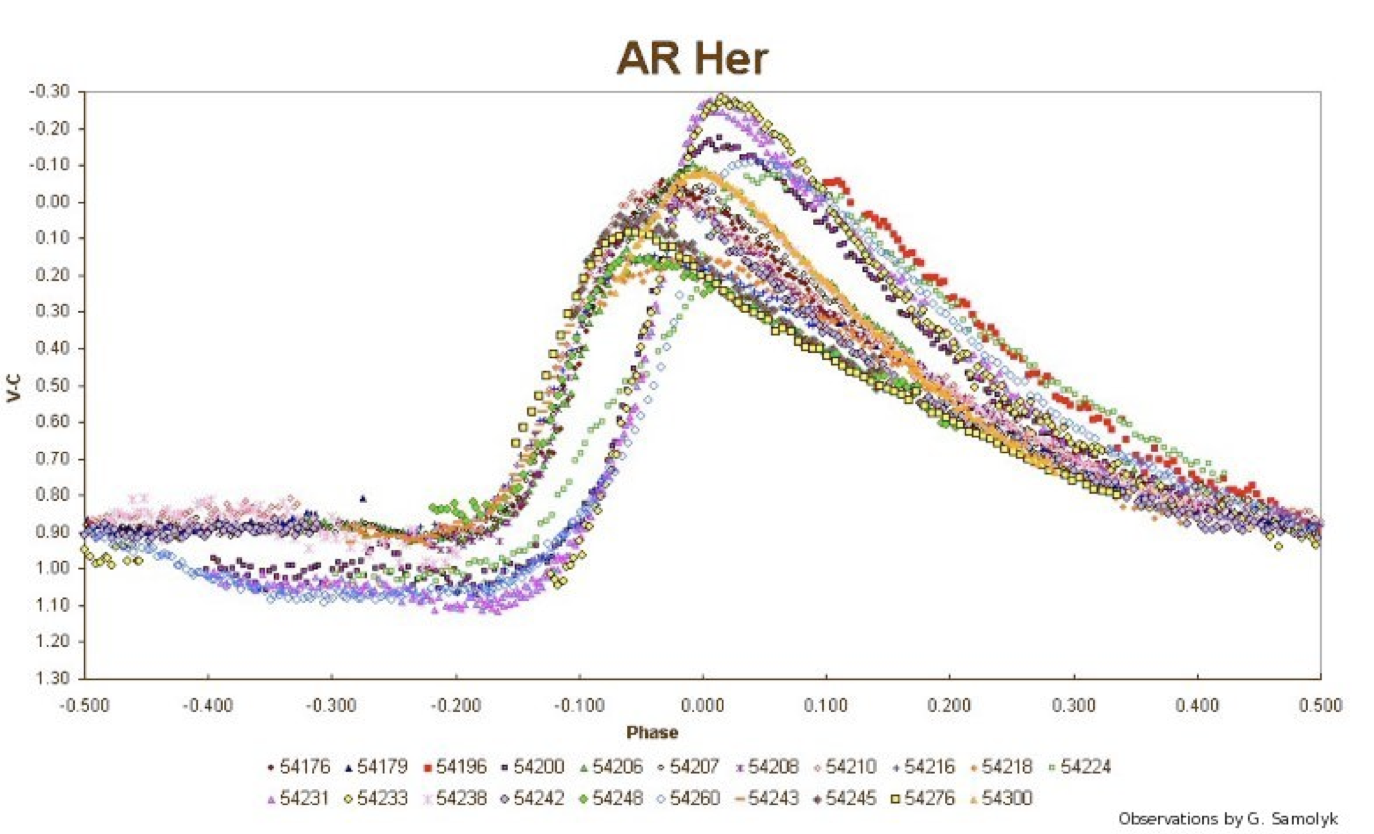

In [8]:
#| label: fig_blazhko
#| fig-cap: light curve of a Blazhko star
Image(filename="../images/blazhko_effect_lc.png")

There is currently no explanation for the Blazhko effect. However, there are plenty of theories and discoveries thus far which help us try to find a solution to this enigma. Stars which are most commonly Blazhko stars are <span style="color:CadetBlue">RR Lyrae</span>. The true incidence rate of Blazhko stars is unknown, since thus far we have had a fairly small sample of the population of RR Lyrae stars. 

### Discoveries and theories

1. <span style="color:CadetBlue">Period Doubling</span>: this effect was discovered in the *Kepler* survey of RR Lyrae stars. In a normal RR Lyrae light curve, there is one peak and one trough during 1 cycle. However, during period doubling, there are 2 maxima and 2 minima, hinting that something more complex is going on. The best theory right now is that period doubling is caused by *resonances between pulsation overtones in RR Lyrae*. 

2. Resonances between fundamental modes and overtones have been shown. This is a strong sign of a potential cause of the Blazhko effect, but we aren't completely sure yet. A theory based entirely on the modes of pulsation is the <span style="color:CadetBlue">Mode mixing theory</span>, when different modes pulsate at the same time. 

3. Another potential theory has been the <span style="color:CadetBlue">Nonadiabatic effect</span>: this is when the star pulsates, different layers of the star push against each other causing luminosity changes and spikes. 

4. There have been some ideas regarding magnetic fields and how the rotation of the field isn't aligned with the star's rotation, however Blazhko stars don't have a very strong magnetic field so this theory probably isn't true. 

5. Finally, the non-radial modes, resonances and period doubling altogether might be the solution to the problem, as they spark low-dimensional chaos in the Blazhko star system, enabling dynamic structures. 

Using the evidence we have so far, we cannot discern which theory is correct, or even think of a new one. We hope that with this project we can bring some insight into this century-old problem.

However, using a well known effect in physics called *interference beats* we can model the effect. When adding 2 sinusoidal waves together with slightly different frequencies, we get the following formula:
$$
     y(t) = sin(2\pi f_1) + sin(2\pi f_2),
$$
we can rewrite it using trigonometric equality
$$
       sin(a) + sin(b) = 2 \, cos({a-b\over 2}) \, sin({a+b\over 2})
$$
as
$$
         y(t) = 2 \, cos(2\pi{f_1-f_2\over 2}) \, sin(2\pi {f_1+f_2\over 2}).
$$ 
When $f_1$ and $f_2$ are similar ($f_1 \approx f_2$), we can define 
$$
         f_o = {f_1+f_2\over 2},
$$         
and 
$$
         \Delta f = |{f_1-f_2\over 2}|,
$$
with $\Delta f << f_o$.

Using the formula above, we can see that the cosine component will cause **amplitudal modulation**, which is visible in the graphs below, depicting interference beats.

In [3]:
plt.rcParams.update({
    'font.serif': 'Andale Mono',
    'font.family': 'serif'
})

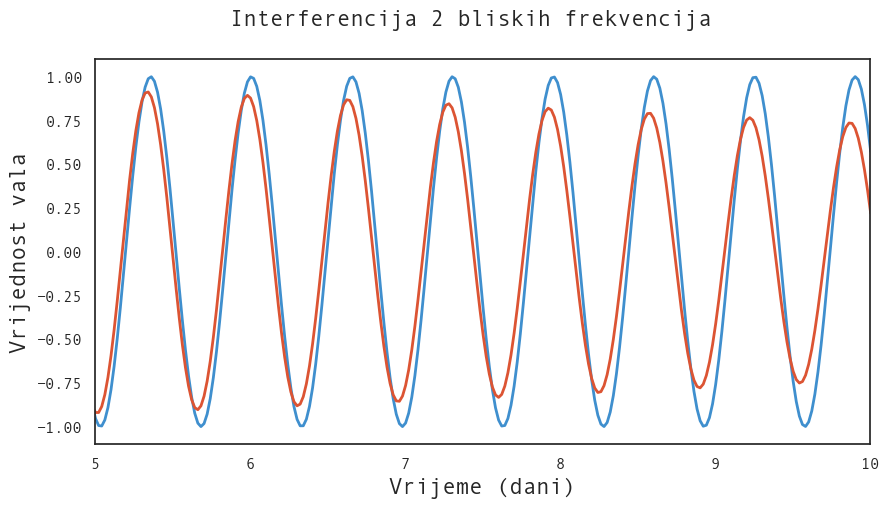

In [5]:
#| code-fold: false
# SIMULATED DATA
Ngrid = 5000  
Tmax = 100     # we generate light curve for times going from 0 to 100 days
maxmagerr = 0.3
# ----
time = np.linspace(0, Tmax, Ngrid)

fn = 1.54 # normal frequency
fblazhko = 1.57 # blazhko frequency
Ablazhko = 0.3 # blazhko amplitude

lcn = np.sin(2*time*fn*3.1415926) # standard light curve data - no modulation 
lc_blazhko = np.sin(2*3.1415926*fblazhko*time)*Ablazhko + lcn # inference beats with the blazhko frequency
lc_blazhko = lc_blazhko/np.max(lc_blazhko) # normalizing to 1 magnitude so scale stays the same

fig = plt.figure(figsize=(10, 5))
fig.suptitle("Interferencija 2 bliskih frekvencija", fontproperties=font,fontsize=16)
plt.plot(time, lcn,c=b2, lw=2)
plt.plot(time,lc_blazhko,c=or3, lw=2)
plt.xlabel("Vrijeme (dani)", fontproperties=font,fontsize=16)
plt.ylabel("Vrijednost vala", fontproperties=font,fontsize=16)
plt.xlim(5,10)
plt.savefig("../img_rsc/interpolation.png", dpi=650)
plt.show()

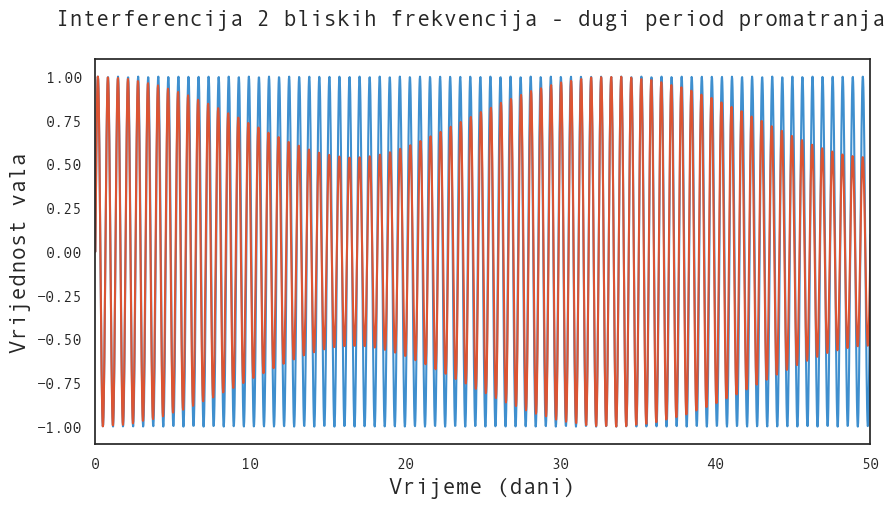

In [8]:
#| code-fold: false

fig = plt.figure(figsize=(10, 5))
fig.suptitle("Interferencija 2 bliskih frekvencija - dugi period promatranja", fontproperties=font,fontsize=16)
plt.plot(time, lcn,c=b2)
plt.plot(time,lc_blazhko,c=or3)
plt.xlabel("Vrijeme (dani)", fontproperties=font,fontsize=16)
plt.ylabel("Vrijednost vala", fontproperties=font,fontsize=16)
plt.xlim(0,50)
plt.savefig("../img_rsc/interpolation2.png", dpi=650)
plt.show()

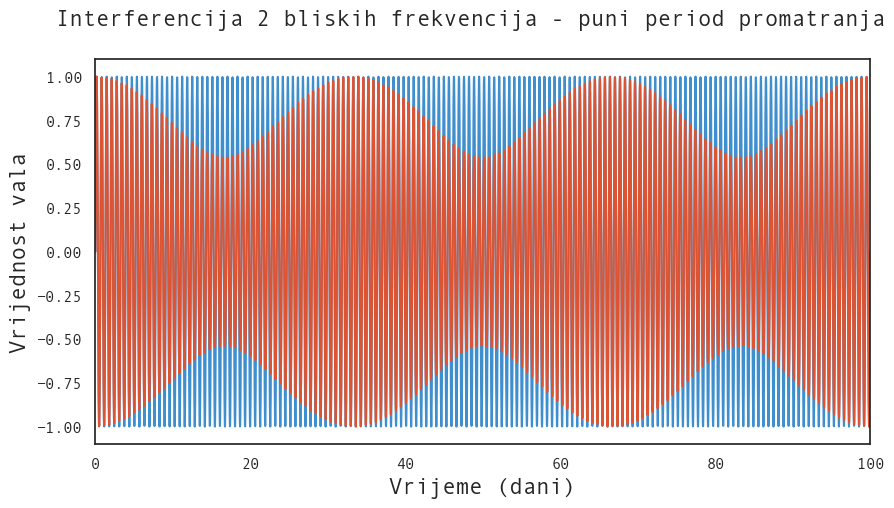

In [9]:
#| code-fold: false

fig = plt.figure(figsize=(10, 5))
fig.suptitle("Interferencija 2 bliskih frekvencija - puni period promatranja", fontproperties=font,fontsize=16)
plt.plot(time, lcn,c=b2)
plt.plot(time,lc_blazhko,c=or3)
plt.xlabel("Vrijeme (dani)", fontproperties=font,fontsize=16)
plt.ylabel("Vrijednost vala", fontproperties=font,fontsize=16)
plt.xlim(0,100)
plt.savefig("../img_rsc/interpolation3.png", dpi=650)
plt.show()

How could we apply interference beats to the Blazhko effect? (bla bla bla)

In [10]:
import random
# SIMULATING LIGHT CURVE
Ngrid = 10000
Tmax = 100

fmain = 1.54
fbl = 1.57

Time = np.linspace(0, Tmax, Ngrid)
lcmain = np.sin(2*3.1415926*Time*fmain)
lc = 2*np.cos(2*3.1415926*Time*(fbl - fmain))*lcmain
lc = lc/np.max(lc)

In [11]:
#| code-fold: false
# SIMULATING OBSERVATION DATA

Ndata = 400
magErr = 0.1
Ablazhko = 0.5
time_data = Tmax * np.random.random(Ndata)

#lcdata = 2*np.cos(2*3.1415926*time_data*(fblazhko-fmain))*np.sin(2*3.1415926*time_data*((fmain+fblazhko)/2))
lcdata = np.sin(2*3.1415926*time_data*fmain) + Ablazhko*np.sin(2*3.1415926*time_data*fblazhko) + Ablazhko*np.sin(2*3.1415926*time_data*(2*fmain-fblazhko))
lcdata = lcdata/np.max(lcdata)
magErrObs = magErr + 0*time_data
LCbObsErr = lcdata + np.random.normal(0, magErrObs)

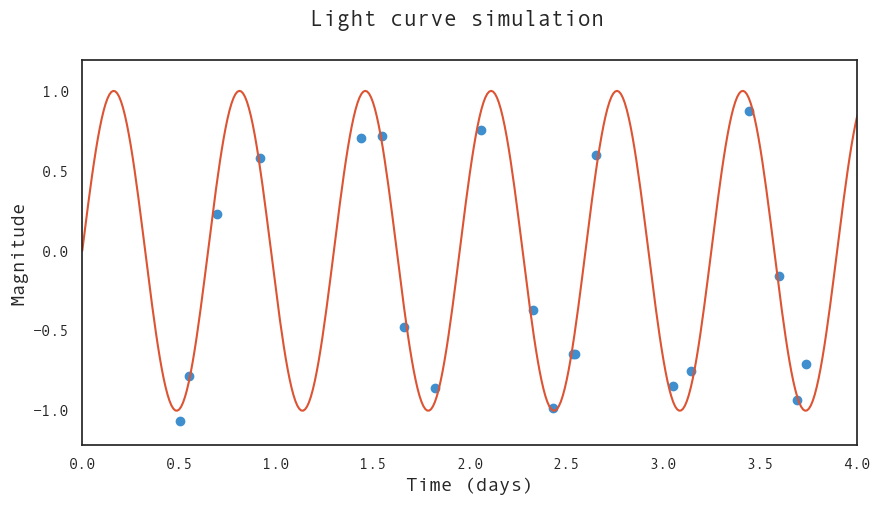

In [12]:
#| code-fold: false
fig = plt.figure(figsize=(10, 5))
fig.suptitle("Light curve simulation", fontproperties=font,fontsize=16)
plt.plot(Time, lcmain, c=or3)
plt.scatter(time_data, LCbObsErr, c=b2)
plt.xlabel('Time (days)',fontproperties=font,fontsize=14)
plt.ylabel('Magnitude', fontproperties=font,fontsize=14)
plt.xlim(0,4)
plt.savefig('../img_rsc/lc_dataeg.png', dpi=650)
plt.show()

What if we try to calculate the period? What would we get? (bla bla bla)

In [13]:
def doPeriods(time, mag, magErr, nterms, lsPS=True, nyquist=100, freqFac=1.05, verbose=True):
    try:
        if verbose:print('Starting calculations...')
        ls = LombScargle(time, mag, magErr, nterms=nterms) # set up a LombScargle object to model the frequency and power
        #frequencyAuto, powerAuto = ls.autopower(nyquist_factor=nyquist) # calculate the frequency and power
        #best_freq = frequencyAuto[np.argmax(powerAuto)]
        # frequency = np.arange(best_freq/freqFac, best_freq*freqFac, 5e-6)
        frequency = np.arange(1.0, 2.0, 5e-5)
        if verbose: print('Arranging frequencies to calculate...')
        power = ls.power(frequency)  # compute LS periodogram again
        period = 1. / frequency
        if verbose: print('Possible periods determined')
        # hack: limit around known frequency to avoid aliases
        powerRestricted = power[(frequency>1.3)&(frequency>1.7)]
        #freqRestricted = frequency[(frequency>1.3)&(frequency>1.7)]
        #periodRestricted = 1. / freqRestricted
        best_period = period[np.argmax(powerRestricted)] # choosing the period with the highest power
        if verbose: print("Best period is ", best_period)
        if lsPS: 
            return best_period, frequency, power
        else:
            return best_period
    except:
        return 'Error in doPeriods'

In [14]:
#| code-fold: false
period, freq, power = doPeriods(time_data, LCbObsErr, magErrObs, nterms=3)

Starting calculations...
Arranging frequencies to calculate...
Possible periods determined
Best period is  0.9218289085544202


---

In [15]:
end = 'ffinal'

# DATA from previous notebook
lc_analysis = pd.read_csv("../outputs/LC_ANALYSIS_"+end+".csv")
rrlyrae = pd.read_csv('../outputs/Lrrlyr_unprocessed.csv')
periodogr = pickle.load(open("../outputs/periodograms_"+end+".pkl", "rb"))
fits = np.load("../outputs/fits_"+end+".npy", allow_pickle=True)
ztf_data = np.load("../outputs/ztf_data_filter"+end+".npy", allow_pickle=True)
FINAL_BE_CATALOGUE = pd.read_csv('../outputs/FINAL_BE_CATALOGUE.csv')

In [17]:
FINAL_BE_CATALOGUE.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_chi2dof,L_chi2dofR,Lmean_chi2dof,Lmean_chi2dofR,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score,period_vs_amp
0,523832,0.372376,0.372384,0.372380,1.000021,251,1.8,1.2,1.9,1.3,...,2.7122,37.3413,0.1528,6.3617,0.17,0.00002,Z,NaN,NaN,NaN
1,1240665,0.632528,0.632522,0.632525,0.999991,468,25.2,3.0,25.4,2.9,...,1.5865,182.3154,0.0570,15.9957,0.00,0.00001,Z,NaN,NaN,NaN
2,1736308,0.555848,0.555843,0.555846,0.999991,372,2.9,1.3,3.0,1.2,...,1.8264,36.6367,0.0529,5.6501,0.11,0.00001,Z,NaN,NaN,NaN
3,2669011,0.591153,0.591151,0.591152,0.999997,450,2.4,1.1,2.3,1.1,...,1.7015,101.2146,0.0751,6.5360,0.16,0.00000,Z,NaN,NaN,NaN
4,2742032,0.629676,0.629692,0.629684,1.000025,514,1.8,0.9,1.9,1.0,...,1.5956,133.2445,0.0602,7.4751,0.34,0.00003,Z,NaN,NaN,NaN


In [64]:
star3 = [3507643]
order = list(FINAL_BE_CATALOGUE['LINEAR id']).index(3507643)
for o, k in enumerate(periodogr):
    if k[0]==star3:
        break

fL = periodogr[o][1][0]
pL = periodogr[o][1][1]

fFoldedL = periodogr[o][1][2]
pFoldedL = periodogr[o][1][3]

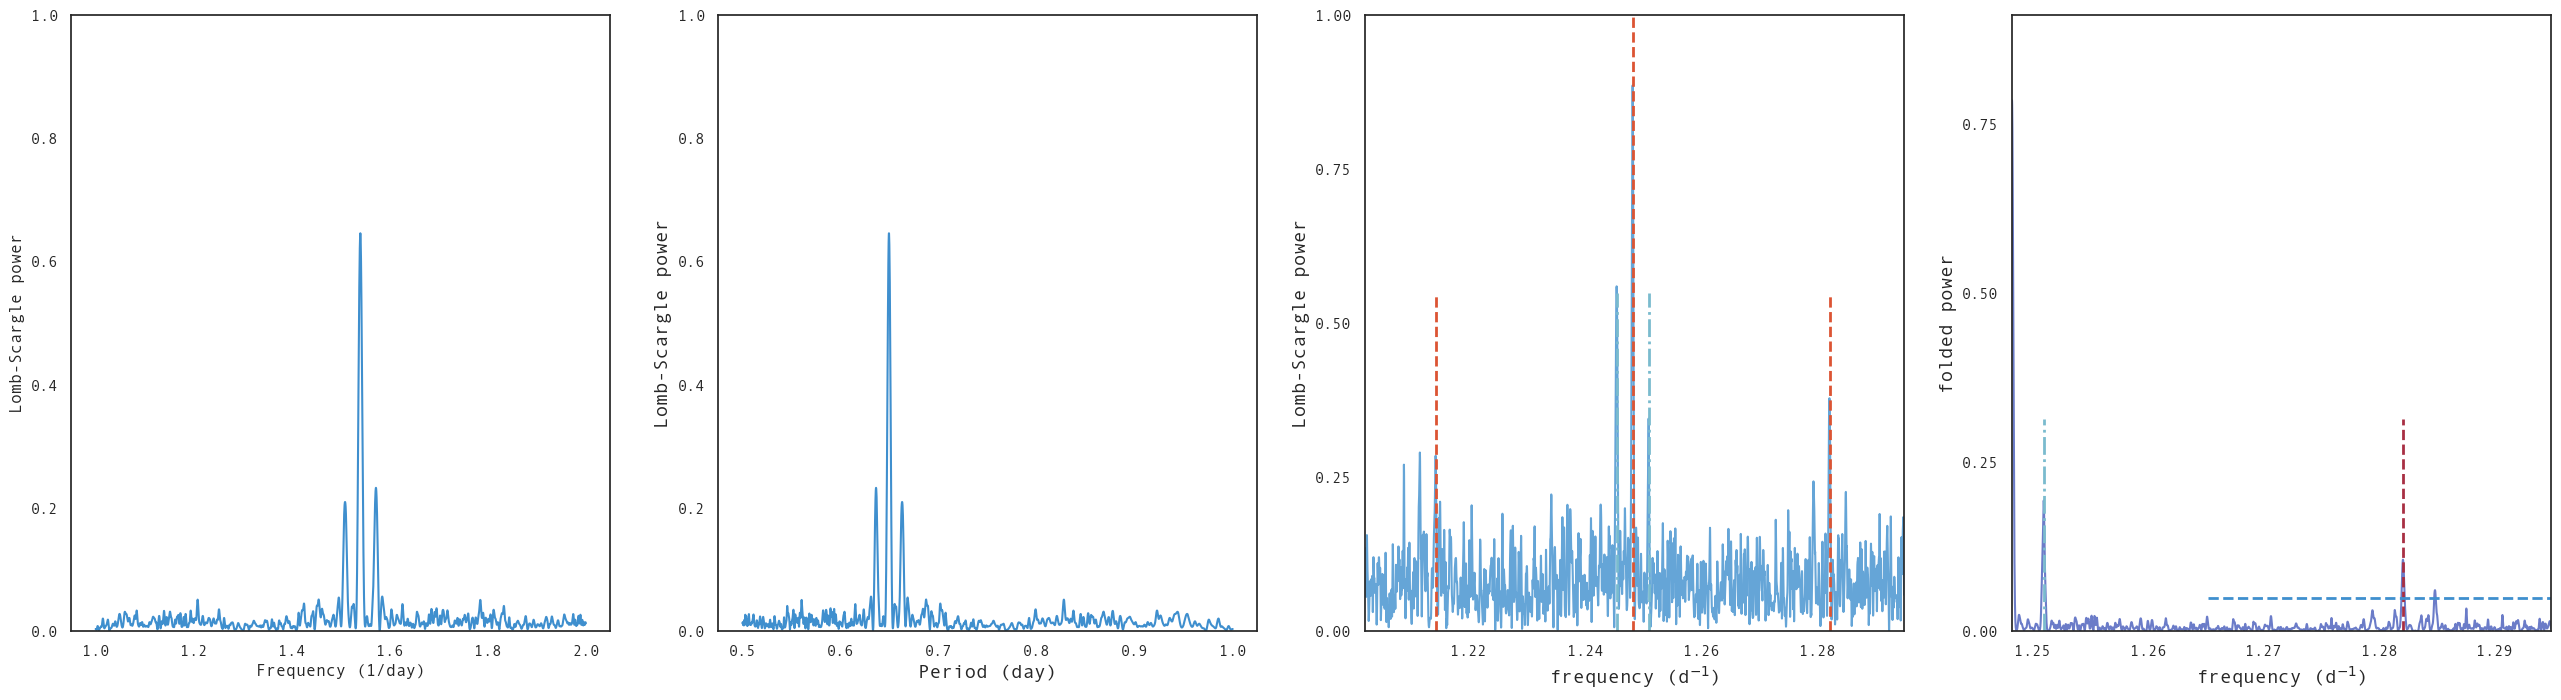

In [69]:
#| code-fold: false
# PLOTTING PERIODOGRAM:
fig = plt.figure(figsize=(32, 8))
fac=1.008

ax = fig.add_subplot(141)
ax.plot(freq, power, c=b2)
ax.set_ylim(0.0,1)
ax.set_ylabel('Lomb-Scargle power', fontproperties=font,fontsize=12)
ax.set_xlabel('Frequency (1/day)', fontproperties=font,fontsize=12)

ax = fig.add_subplot(142)
ax.plot(1/freq, power, c=b2)
ax.set_ylim(0.0,1)
ax.set_ylabel('Lomb-Scargle power', fontproperties=font,fontsize=14)
ax.set_xlabel('Period (day)', fontproperties=font,fontsize=14)

flin = fL[np.argmax(pL)]

# DATA PREP
# ===========
fBlazhkoPeakL = FINAL_BE_CATALOGUE['BlazhkoPeakL'][order]
# ---
fBlazhkoPeakZ = FINAL_BE_CATALOGUE['BlazhkoPeakZ'][order]

ax = fig.add_subplot(143)

ax.plot(fL, pL, c=b2, alpha=0.8)
ax.plot([flin, flin], [0,1], lw = 2, c=or3, ls='--')
ax.plot([fBlazhkoPeakL, fBlazhkoPeakL], [0, 0.7*np.max(pFoldedL)], lw = 2, c=or3, ls='--')
ax.plot([2*flin-fBlazhkoPeakL, 2*flin-fBlazhkoPeakL], [0, 0.7*np.max(pFoldedL)], lw = 2, c=or3, ls='--')
# show 1 year alias
f1yr = flin+1/365.0
ax.plot([f1yr, f1yr], [0,0.7*np.max(pFoldedL)], lw = 2, ls='-.', c=b3)
f1yr = flin-1/365.0
ax.plot([f1yr, f1yr], [0,0.7*np.max(pFoldedL)], lw = 2, ls='-.', c=b3)

#ax.text(0.03, 0.96, "LINEAR", ha='left', va='top', transform=ax.transAxes,fontproperties=font, fontsize=10)
if (fBlazhkoPeakL > flin*fac):
    ax.set_xlim(0.99*(2*flin-fBlazhkoPeakL), 1.01*fBlazhkoPeakL)
else:
    ax.set_xlim(flin/fac, flin*fac)
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

ylim = ax.get_ylim()
ymax = ylim[0] + 1.1 * (ylim[1] - ylim[0])
if ymax>1.0: ymax=1.0
ax.set_ylim(0, ymax)
ax.set_ylabel('Lomb-Scargle power',fontproperties=font, fontsize=14)
ax.set_xlabel('frequency (d$^{-1}$)',fontproperties=font, fontsize=14)

# plot folder power spectrum
ax = fig.add_subplot(144)

ax.plot(fFoldedL, pFoldedL, c=b1, alpha=0.8)
ax.plot([fBlazhkoPeakL, fBlazhkoPeakL], [0,0.4*np.max(pFoldedL)], lw = 2, ls='--', c=or1)
# show 1 year alias
f1yr = flin+1/365.0
ax.plot([f1yr, f1yr], [0,0.4*np.max(pFoldedL)], lw = 2, ls='-.', c=b3)

powerFar = pFoldedL[fFoldedL>fBlazhkoPeakL]  # frequencies beyond the second peak
powerFarMedian = np.median(powerFar)      # the median power
powerFarRMS = np.std(powerFar)            # standard deviation, i.e. "sigma"
noise5sig = powerFarMedian+5*powerFarRMS

if (fBlazhkoPeakL > flin*fac):
    ax.plot([flin+0.5*(fBlazhkoPeakL-flin), 1.01*fBlazhkoPeakL], [noise5sig, noise5sig], lw = 2, ls='--', c=b2)
    ax.set_xlim(flin, 1.01*fBlazhkoPeakL)
else:
    ax.plot([flin+0.5*(fBlazhkoPeakL-flin), flin*fac], [noise5sig, noise5sig], lw = 2, ls='--', c=b2)
    ax.set_xlim(flin, flin*fac)

ax.yaxis.set_major_locator(plt.MaxNLocator(4))

ylim = ax.get_ylim()
ymax = ylim[0] + 1.1 * (ylim[1] - ylim[0])
if ymax>1.0: ymax=1.0
ax.set_ylim(0, ymax)
ax.set_ylabel('folded power',fontproperties=font, fontsize=14)
ax.set_xlabel('frequency (d$^{-1}$)',fontproperties=font, fontsize=14)

plt.savefig("../img_rsc/periodogrameg2.png",dpi=50)
plt.show()

---

### Long period variables

These variable stars are red giants or supergiants with very long periods, ranging from 30 to 1000 days. The two subclasses are **Mira and Semiregular stars**.

**Mira stars** are variables with periods from 80 to 1000 days and significant amplitude changes. Mira stars pulsate radially, and while doing so, they eject lots of material from their surfaces. A unique aspect of Mira variables is that during their cooling process, they form TiO molecules, which absorb all of the incoming light from the star, making it appear even dimmer, thus adding to the meaningful amplitude changes.

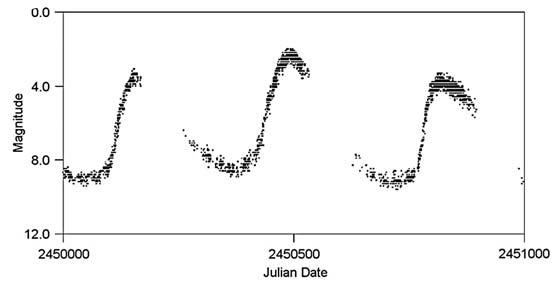

In [7]:
#| label: fig_mira
#| fig-cap: light curve of a Mira variable star, reference https://www.researchgate.net/figure/left-Mira-variable-star-light-curve-Omicron-Ceti-Image-courtesy-of-AAVSO-Cambridge_fig6_260163531
Image(filename="../images/mira.png")

**Semiregular variables**, as the name suggests, do not have completely regular periods. They are typically supergiants, with a regular period for some amount of time before irregularity occurs—their "periods" last from 20 to 2000 days, with amplitude changes lower than 2.5.

There are four types of semiregular variables.
1. **SRA types:** These stars have minimal amplitude changes and periods typically from 35-1200 days, which are relatively regular.
2. **SRB types:** These stars do not have a specific period (usually 20 to 2300 days). The period exhibits slow and irregular changes.
3. **SRC types:** These stars have small amplitudes of around one magnitude and have variations in the periods (from 30 to thousands of days).
4. **SRD types:** These giants and supergiants of types F, G, or K have small amplitudes ranging from 0.1 to 4. Their periods range from 30 to 1100 days. 

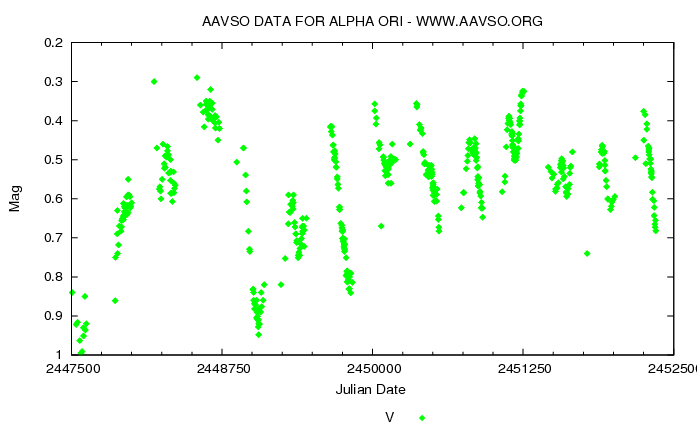

In [10]:
#| label: fig_semi
#| fig-cap: light curve of a semiregular variable star, reference https://en.wikipedia.org/wiki/Semiregular_variable_star
Image(filename="../images/semiregular.png")

Other types of pulsating stars include RV Tauri stars, W Virginis variables, Delta-scuti variables and Sx Phoenix variables.

### Cataclysmic stars
These stars undergo sudden outbursts of energy, resulting in a rapid increase in brightness and a slow decline.
### Supernova, Nova, Recurrent novas and Dwarf nova

Supernovae are some of the brightest events in the universe, with an amplitude of around 20 magnitudes or more. There are four types of supernovae:
1. Type 1a: These types of supernovae occur in a binary star system where one component is a white dwarf and the other a giant star. In this system, the white dwarf accretes mass from the giant star, and once it passes the Chandrasekhar limit, it explodes, resulting in a supernova.
2. Types II, Ib, and Ic occur when massive stars collapse and explode due to immense pressure.

Novas are also events in binary star systems, where one component is a white dwarf and the other a giant star. The white dwarf accretes material into its atmosphere, and once it grows hot enough, it starts nuclear fusion reactions, and due to the immense energy released, it explodes into a nova. If the system's parameters enable it, these systems can become recurrent novae, meaning these explosions repeat periodically.

Finally, dwarf novae are very similar to novae, except they form an accretion disk around themselves, and the disk begins nuclear fusion rather than the atmosphere. These explosions are typically much smaller in magnitude compared to novae or supernovae. 

Other types of cataclysmic stars are symbiotic stars and R Coronae Borealis stars. In symbiotic stars, we have a binary system where matter constantly flows from one star to the other, and the changing shape of both stars contributes to the variability. In R Coronae Borealis, stars are unique because the formation of carbon-rich dust that envelopes the star's surface is responsible for the star's dimming.

### Eruptive variable stars
### Flare stars, S Doradus stars and Wolf-Rayet stars

Flare stars are faint red dwarfs that exhibit sudden changes in brightness due to flares, similar to solar flares. They occur when the large magnetic loops on the stellar surface break and release significant quantities of energy.

S Doradus stars are also known as Luminous Blue variables. They are short-lived stars, which are variables due to a combination of pulsations, eruptions, changes in the star's atmosphere, or due to the loss of material.

Wolf-Rayet stars are old and massive stars that constantly lose mass due to solar winds. They are poorly understood, and we do not know much about them.

### Young stellar objects

T Tau variables are young protostars or objects which have yet to become stars because they have not begun nuclear fusion. Their variability is caused by numerous factors which change a lot during a star's formation process, like the protoplanetary disk's accretion rate, rotation, starspots, and other factors.

FU Orionis variables are also very young stellar objects like T Tau variables. They have a gradual increase in magnitude by 4 to 6 magnitudes. They stay at their maximum brightness for many years before slowly dimming to their standard brightness.

EXor variables are eruptive T Tauri stars. They erupt and brighten over a few months and then dim. The pattern generally repeats. 

Finally, we have UXor variables. Their nature is poorly understood, but we know they are pre-main sequence stars with irregular periods. 

## Extrinsic variable stars
These types of stars are not changing in shape or volume; instead, external influences cause their variability.

### Eclipsing binaries

These are one of the most interesting variable types. These variables are a binary system, where one star passes before the other, light is blocked, and the magnitude decreases. The change in luminosity depends on the two stars' sizes, distance, and geometry. Even for slightly different star systems, the light curves can look completely different. There are many types of eclipsing binaries, but three distinct types are Algol variables, Beta Lyrae variables, and W Ursae Majoris variables. 


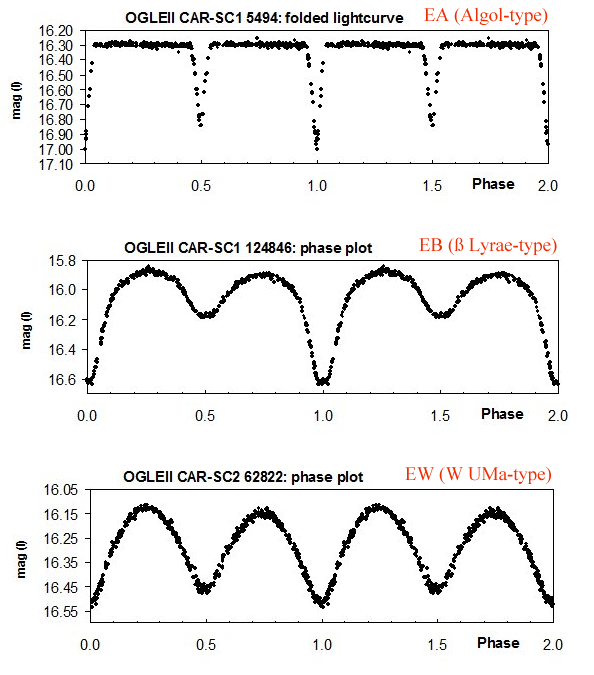

In [11]:
#| label: fig_eclipsing
#| fig-cap: a light curve of an eclipsing binary, reference https://vs-compas.belastro.net/bulletin/issue/2/p6
Image(filename="../images/eclipsing-b.png")

### Rotating variables

Pulsars are rapidly rotating neutron stars that emit pulses of radiation in regular periods due to a beam of radiation that sweeps out of both ends of the star as it rotates. Their periods are a few milliseconds long. 

Ellipsoidal stars are parts of binary systems where the two components are close enough not to be spherical anymore. Due to the high gravitational forces, the stars are ellipsoidal, and depending on how much surface area we see from Earth, that is how bright the star is at the moment.

Magnetic variables are stars whose cause of variability is magnetic fields. There are two types: polars and intermediate polars.
Intermediate polar are stars in binary systems where one is a white dwarf, and another is a low-mass secondary star. As an accretion disk forms around the white dwarf due to matter flowing from the low-mass star, it is disrupted around the white dwarf due to a powerful magnetic field. Because of this, there are sudden peaks of brightness that fade out over a long time.
Polars are stars in the same system as previously described. However, the magnetic field is even more powerful, so the stars are tidally locked, rotating at the same speed around each other. The stream of matter enters the magnetic field, causing an X-ray shock, which is the cause for spikes in brightness which fade out relatively quickly. 

Some stars where stellar spots are the reason for their variability are By Dra variables and RS CVn variables. Gamma Cas stars are variables that change brightness due to the formation of rings around their equator or disk formation. 


### Microlensing variables

Furthermore, we have microlensing variables. These variables brighten and dim when some object, which acts as a gravitational lens, passes in front of the star from our point of view, which magnifies the star's light. As it passes, the star's brightness dims. 

---

In the following notebooks we present our methodology, research process and results of our search for new Blazhko stars and possible new trends in their data.